- Implement fit for variability only (with ability to hold specific mean parameters)

In [148]:
from Modeling import model
from mygp import gp, kernel
import numpy as np
import batman 
import warnings
import matplotlib.pyplot as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.style.use('seaborn-deep')

import warnings
warnings.simplefilter('ignore')
import copy

import sys
sys.path.insert(0, '/Users/tgordon/research/libra/')
from libra import ObservationArchive, nirspec_pixel_wavelengths
import corner
import utilities

def map_likelihood(center, duration, depth, model):
    
    log_like = np.zeros((len(duration), len(center)))
    
    for i, c in enumerate(center):
        for j, d in enumerate(duration):
            mean_params = [0, depth, c, d]
            initial_fit.update_gp(mean_params=mean_params)
            initial_fit.gp.compute(t)
            log_like[j][i] = initial_fit.gp.log_likelihood(data, t)
    return log_like

def map_likelihood_withmin(center, duration, depth, model):
    
    log_like = np.zeros((len(duration), len(center)))
    
    for i, c in enumerate(center):
        for j, d in enumerate(duration):
            model = copy.deepcopy(initial_fit)
            mean_params = [0, depth, c, d]
            model.update_gp(mean_params=mean_params)
            model.fit_variability(data, t)
            log_like[j][i] = model.gp.log_likelihood(data, t)
            print('finished minimization for c={:.2f}, d={:.2f}'.format(c, d))
            print('with parameters: ')
            model.print_params()
            print('---------------------------------------------')
    return log_like

def plot_likelihood_map(log_like, center, duration, vmin=None):
    fig = pl.figure(figsize=(10, 10))
    pl.pcolormesh(center, duration, log_like, vmin=vmin)

def transit(t, log_off, b, rp, t0, dt):
    
    t = np.array(t)
    T0 = dt*np.sqrt(1-b**2)/(1 - b**2 + rp)
    
    params = batman.TransitParams()
    params.t0 = t0                       
    params.per = 100                      
    params.rp = rp                      
    params.a = params.per/(T0*np.pi)                       
    params.inc = np.arccos(b/params.a)*(180/np.pi)                     
    params.ecc = 0.                      
    params.w = 90. 
    
    u1, u2 = 0.1, 0.3
    d4 = -u2
    d2 = u1 + 2*u2
    d1, d3 = 0, 0
    
    params.u = [u1, u2]                
    params.limb_dark = "quadratic" 
    
    m = batman.TransitModel(params, t)    
    return log_off*m.light_curve(params)

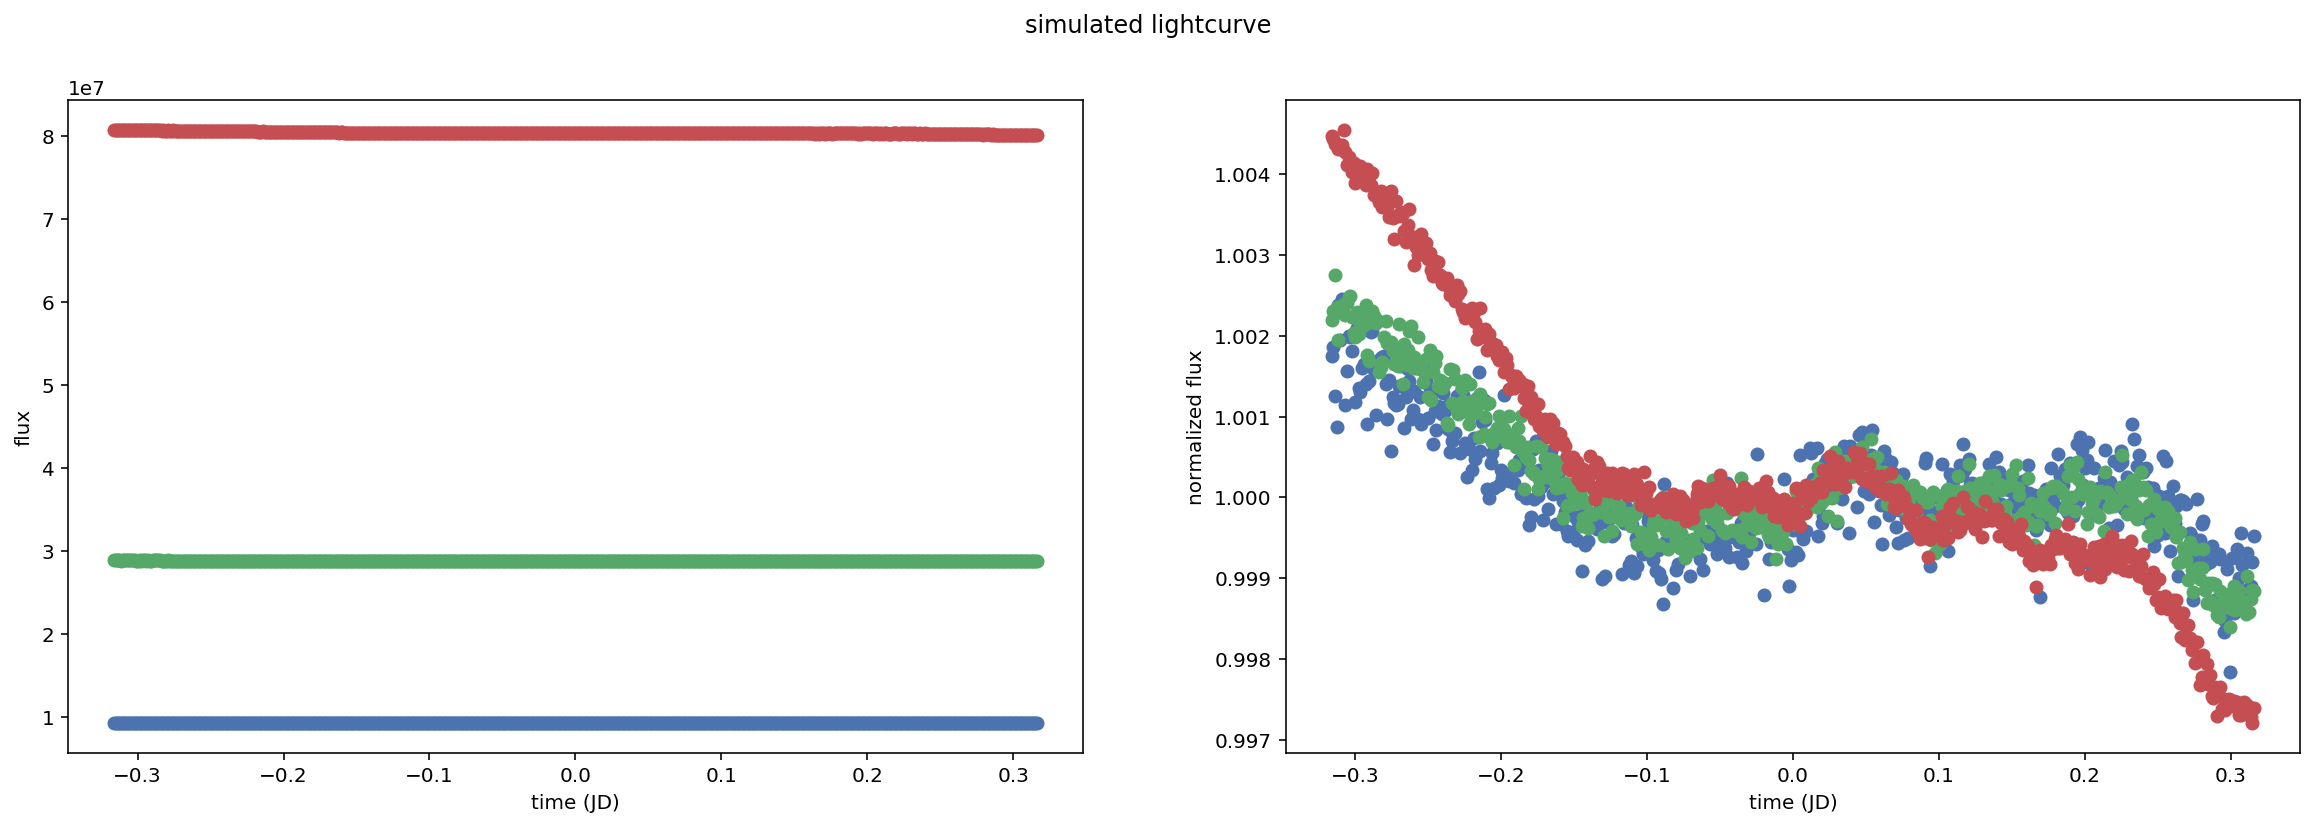

In [142]:
# get and plot data

basedir = '/Users/tgordon/research/libra/notebooks/'
data = np.loadtxt(basedir + 'tyler6_b_binned.txt')
t = data[0] - np.median(data[0])

real_r = 1.380639388298003645e-02
real_c = 2.448309552864564583e+06 - np.median(data[0])
real_d = 0.070046690

figure = pl.figure(figsize=(12, 10))
data = data[::-1]
data = data[:-1]

utilities.plot_samples(data, t, 'simulated lightcurve');

k1_params:  [0.1, 50000000.0]
k2_params:  [4, 15]
mean_params:  [0.0, 0.0, 0.0, 0.1]
white_noise:  [4000.0, 4000.0, 6000.0]
offsets:  [9254248.272186765, 28748826.171179015, 80331908.13902321]


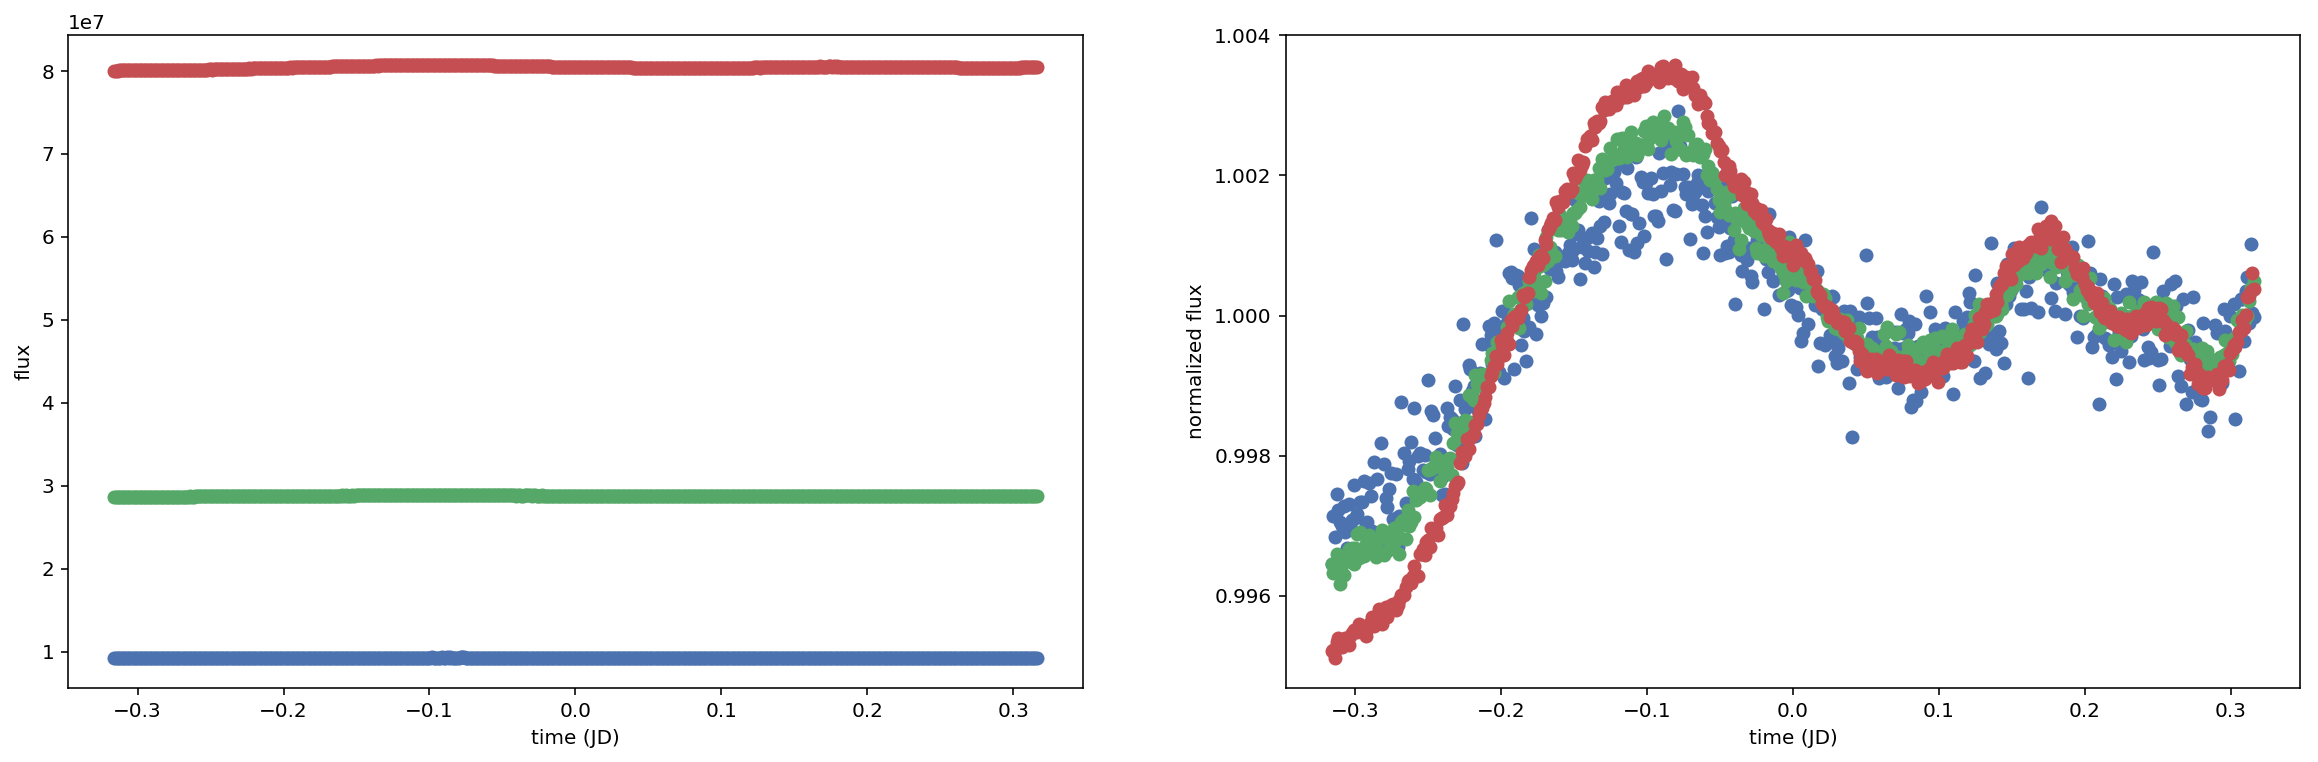

In [19]:
# do initial fit to variability 
    
k1_params = [0.1, 5e7]
k2_params = [4, 15]
white_noise = [4e3, 4e3, 6e3]
offsets = [np.median(data[0]), np.median(data[1]), np.median(data[2])]
mean_params = [0.0, 0.0, 0.0, 0.1]

initial_fit = model(k1_params, k2_params, white_noise, mean_params, offsets, transit, 
                    kernel.celerite_root2_kernel, kernel.scale_kernel, 3)

#%time initial_fit.fit_variability(data, t, method='L-BFGS-B')
utilities.plot_samples(initial_fit.sample(t), t)
initial_fit.print_params()

In [ ]:
center = np.linspace(t.min(), t.max(), 10)
duration = np.linspace(0.01, 0.5, 10)
like = map_likelihood(center, duration, 0.027, initial_fit)

In [ ]:
plot_likelihood_map(like, center, duration)
pl.title('Log Likelihood')
pl.xlabel('Center of Transit (days)')
pl.ylabel('Transit Duration (days)')

#pl.axvline(real_c)
#pl.axhline(real_d)

In [ ]:
center = np.linspace(t.min(), t.max(), 50)
duration = np.linspace(0.01, 0.5, 50)
like = map_likelihood(center, duration, 0.024, initial_fit)

In [ ]:
plot_likelihood_map(like, center, duration)
pl.title('Log Likelihood')
pl.xlabel('Center of Transit (days)')
pl.ylabel('Transit Duration (days)')

#pl.axvline(real_c)
#pl.axhline(real_d)
pl.axvline(0.16)
pl.axhline(0.08)

In [3]:
n = 50
depth_like = np.zeros(n)
depth = np.linspace(0.0, 0.03, n)
c, d, r, b = real_c, real_d, real_r, 0.0

#for i in range(n):
#    initial_fit.update_gp(mean_params=[b, depth[i], c, d])
#    initial_fit.gp.compute(t)
#    depth_like[i] = initial_fit.gp.log_likelihood(data, t)
#pl.plot(depth, depth_like)

In [ ]:
pl.plot(depth, depth_like)
pl.ylim(-9530, -9520)

In [ ]:
depth[list(depth_like).index(np.max(depth_like))]

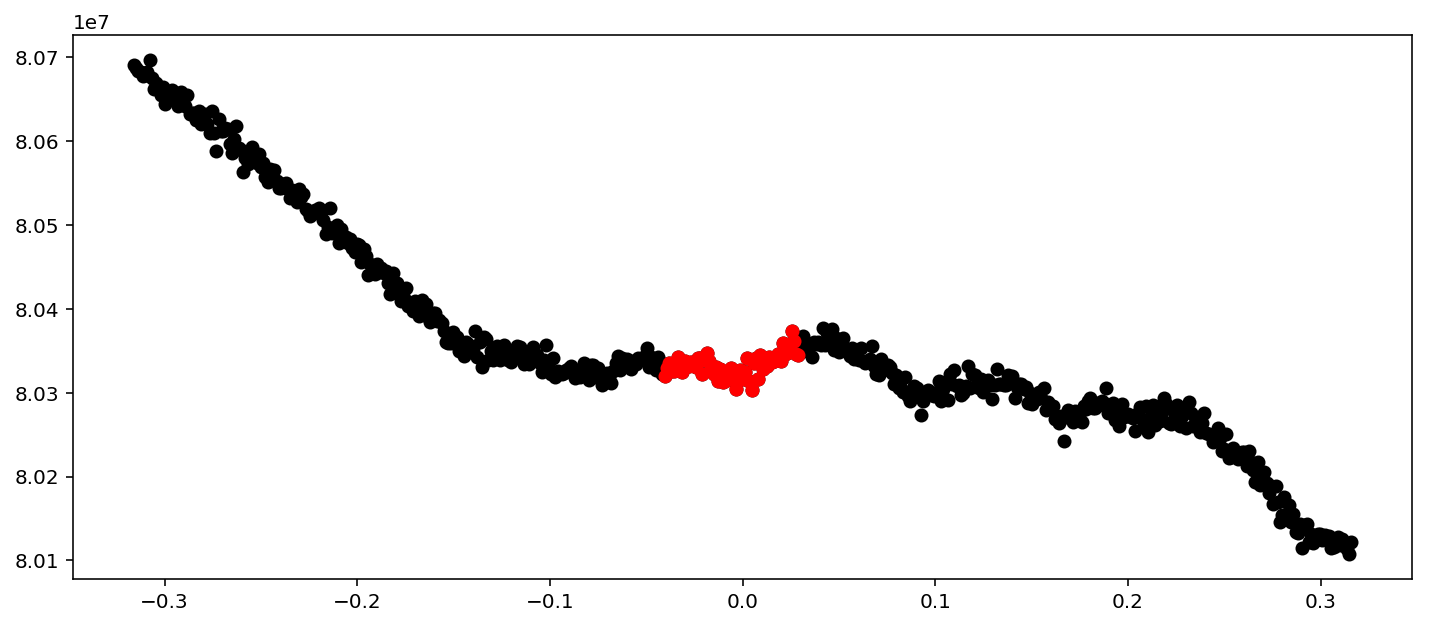

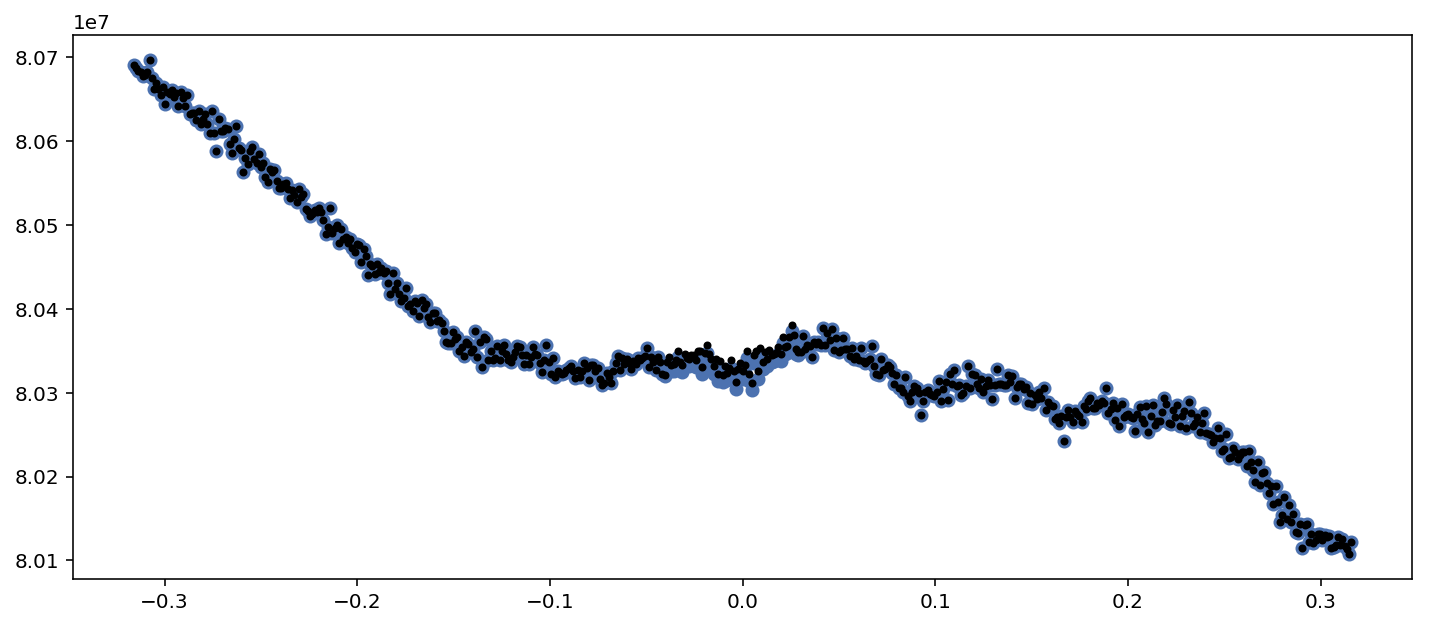

In [143]:
lc = data[2]

fig = pl.figure(figsize=(12, 5))
pl.plot(t, lc, 'ko', alpha=1)
r = 0.01

in_transit = lc[np.abs(t-c)<d/2]
t_in_transit = t[np.abs(t-c)<d/2]
pl.plot(t_in_transit, in_transit, 'ro')

mean_params = [b, r, c, d]
#initial_fit.update_gp(mean_params=mean_params)
#initial_fit.gp.compute(t)

fig = pl.figure(figsize=(12, 5))
#pl.plot(t_in_transit, in_transit, 'ro', alpha=0.3)
pl.plot(t, lc, 'o')
pl.plot(t, lc + np.median(lc) - transit(t, np.median(lc), b, r, c, d), 'k.')



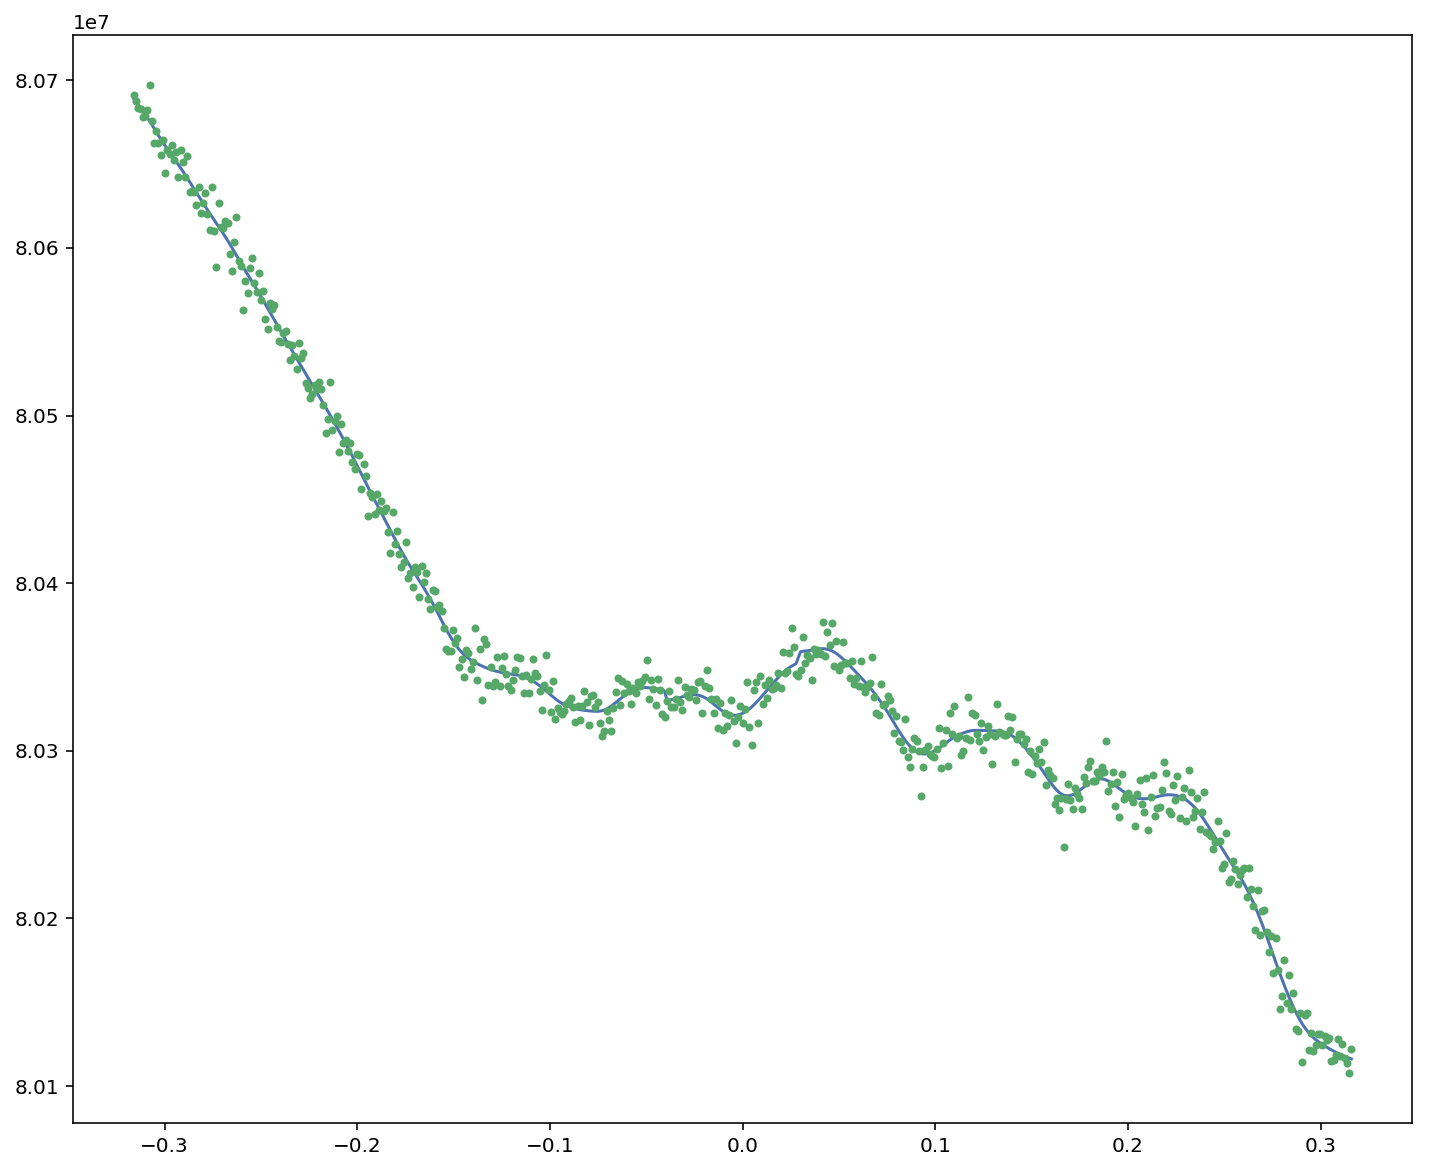

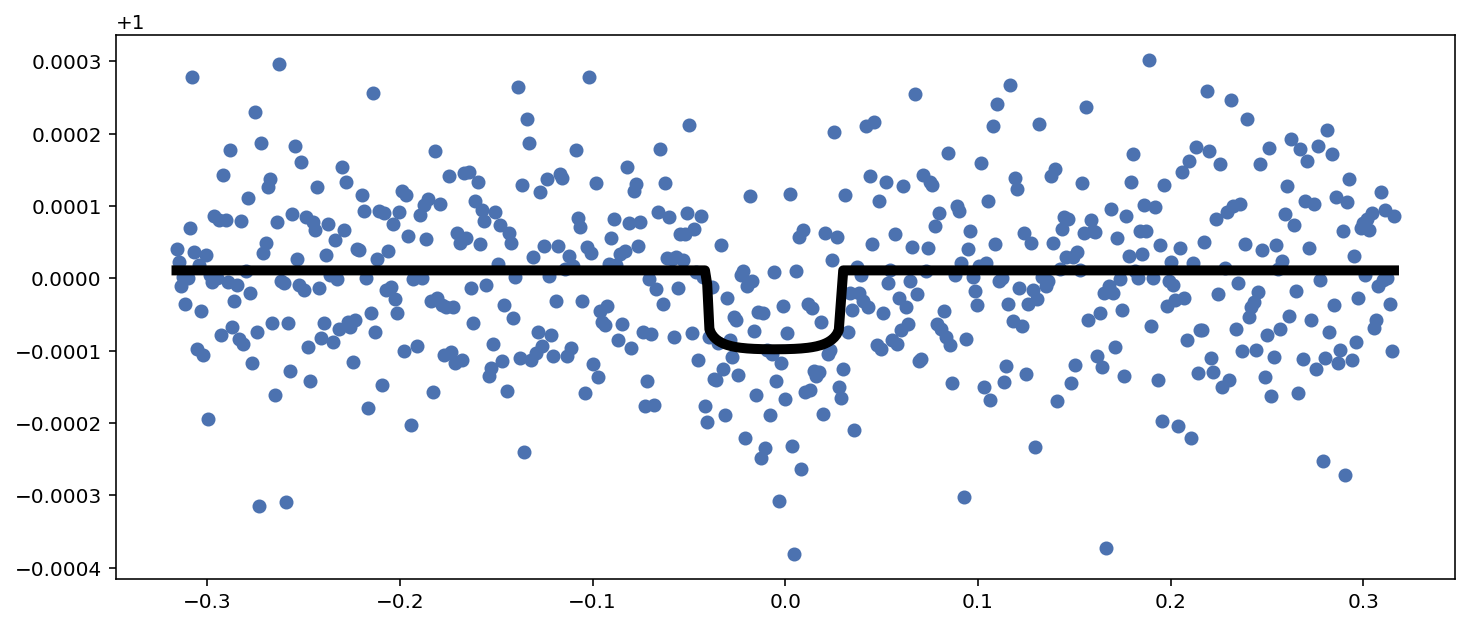

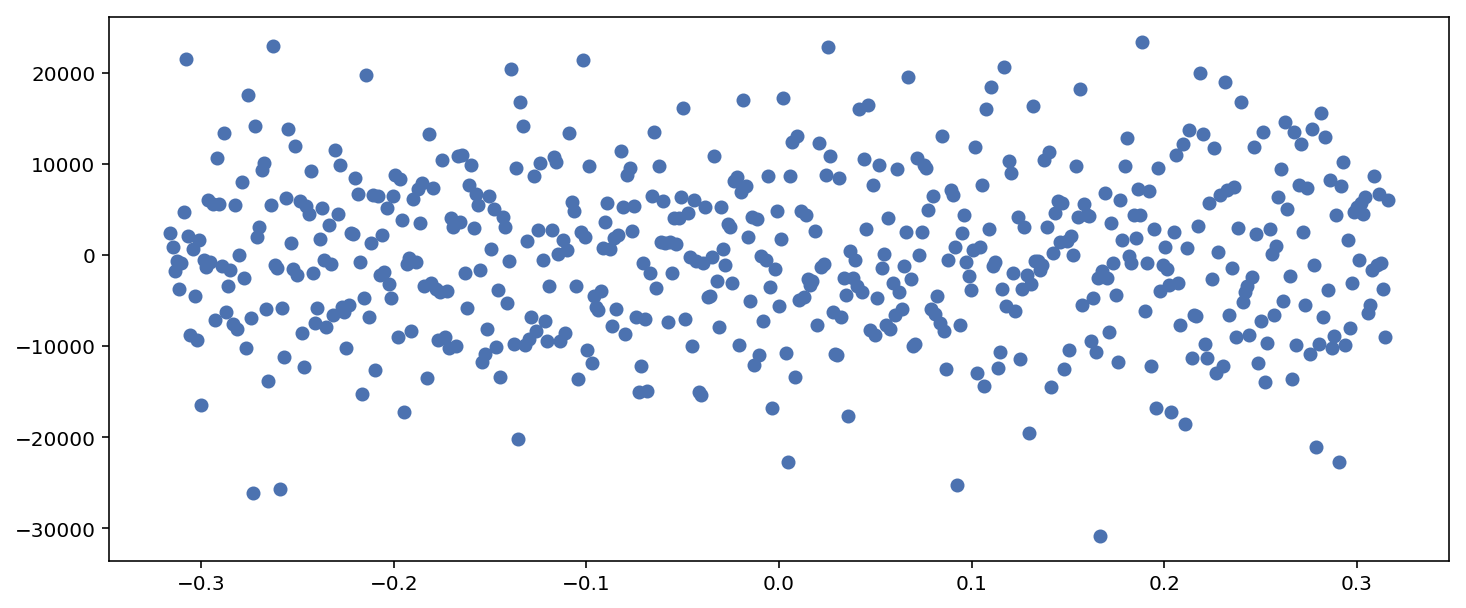

In [144]:
# Use celerite to smooth variability:

import celerite
from celerite.modeling import Model
from celerite import terms

class MeanModel(Model):
    parameter_names=('log_off', 'b', 'rp', 'center', 'duration')
    
    def get_value(self, t):
        return transit(t, self.log_off, self.b, self.rp, self.center, self.duration)

Q = 1./np.sqrt(2)
w0 = 1./initial_fit.k1_params[0]
S0 = initial_fit.k1_params[1]

transit_model = MeanModel(log_off=initial_fit.offsets[2], b=0, rp=r, center=c, duration=d)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0))
gp = celerite.GP(kernel, mean=transit_model)
gp.compute(t, yerr=1e3)
mu, var = gp.predict(data[2], t, return_var=True)

fig = pl.figure(figsize=(12, 10))
pl.plot(t, mu)
pl.plot(t, data[2], '.')

fig = pl.figure(figsize=(12, 5))
planet = transit(t, initial_fit.offsets[2], b, r, c, d)
pl.plot(t, (data[2]-mu+planet)/np.median(data[2]-mu+planet), 'o')
pl.plot(t, planet/np.median(data[2]-mu+planet), 'k', linewidth=5)

fig = pl.figure(figsize=(12, 5))
pl.plot(t, data[2]-mu, 'o')

In [77]:
bins = bins[::-1]
data = data[::-1]

Text(0.5,0,'Time (hours)')

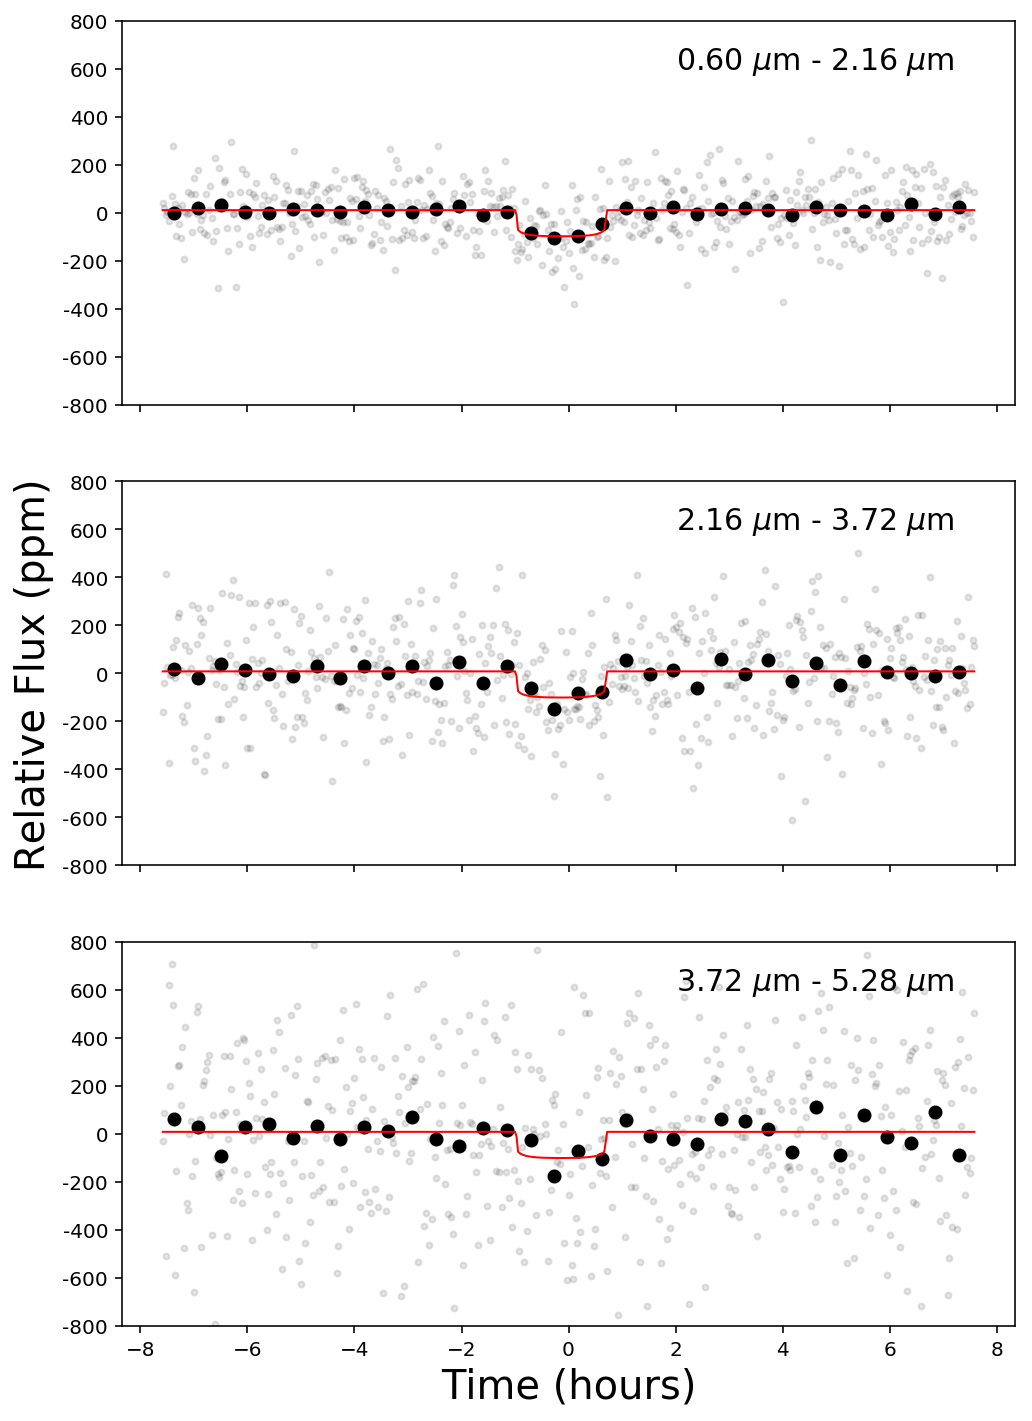

In [145]:
from matplotlib.ticker import FormatStrFormatter

yerr = 3e3, 2e3, 1e3
fig, axs = pl.subplots(3, 1, figsize=(8, 12), sharex='all')
#axs[0].set_title('Best-fit Transit with Micro-variability Filtered', size=20)
bins = np.linspace(5.28, 0.6, 4)

def bin(t, data, n):
    binned = [np.mean(data[i-n:i+n]) for i in range(n, len(data)-n, 2*n)]
    binned_t = [np.mean(t[i-n:i+n]) for i in range(n, len(t)-10, 2*n)]
    return binned_t, binned

for i, dat in enumerate(data):
    transit_model = MeanModel(log_off=initial_fit.offsets[i], b=0.95, rp=r, center=c, duration=d)
    gp = celerite.GP(kernel, mean=transit_model)
    gp.compute(t, yerr=yerr[i])
    mu, var = gp.predict(dat, t, return_var=True)
    planet = transit(t, initial_fit.offsets[i], b, r, c, d)
    detrended = 1e6*((dat-mu+planet)/np.median(dat-mu+planet)-1)
    binned_t, detrended_binned = bin(t, detrended, 8)
    axs[2-i].plot(t*24, detrended, 'k.', alpha=0.1)
    axs[2-i].plot(np.array(binned_t)*24, detrended_binned, 'ko')
    axs[2-i].plot(t*24, 1e6*(planet/np.median(dat-mu+planet)-1), 'r', linewidth=1)
    axs[2-i].yaxis.set_major_formatter(FormatStrFormatter('%3.f'))
    axs[2-i].set_ylim([-800, 800])
    axs[2-i].text(2, 600, r'{:.2f} $\mu$m - {:.2f} $\mu$m'.format(bins[i+1], bins[i]), size=15)
        
axs[1].set_ylabel('Relative Flux (ppm)', size=20)
pl.xlabel('Time (hours)', size=20)

Text(0.5,0,'Time (hours)')

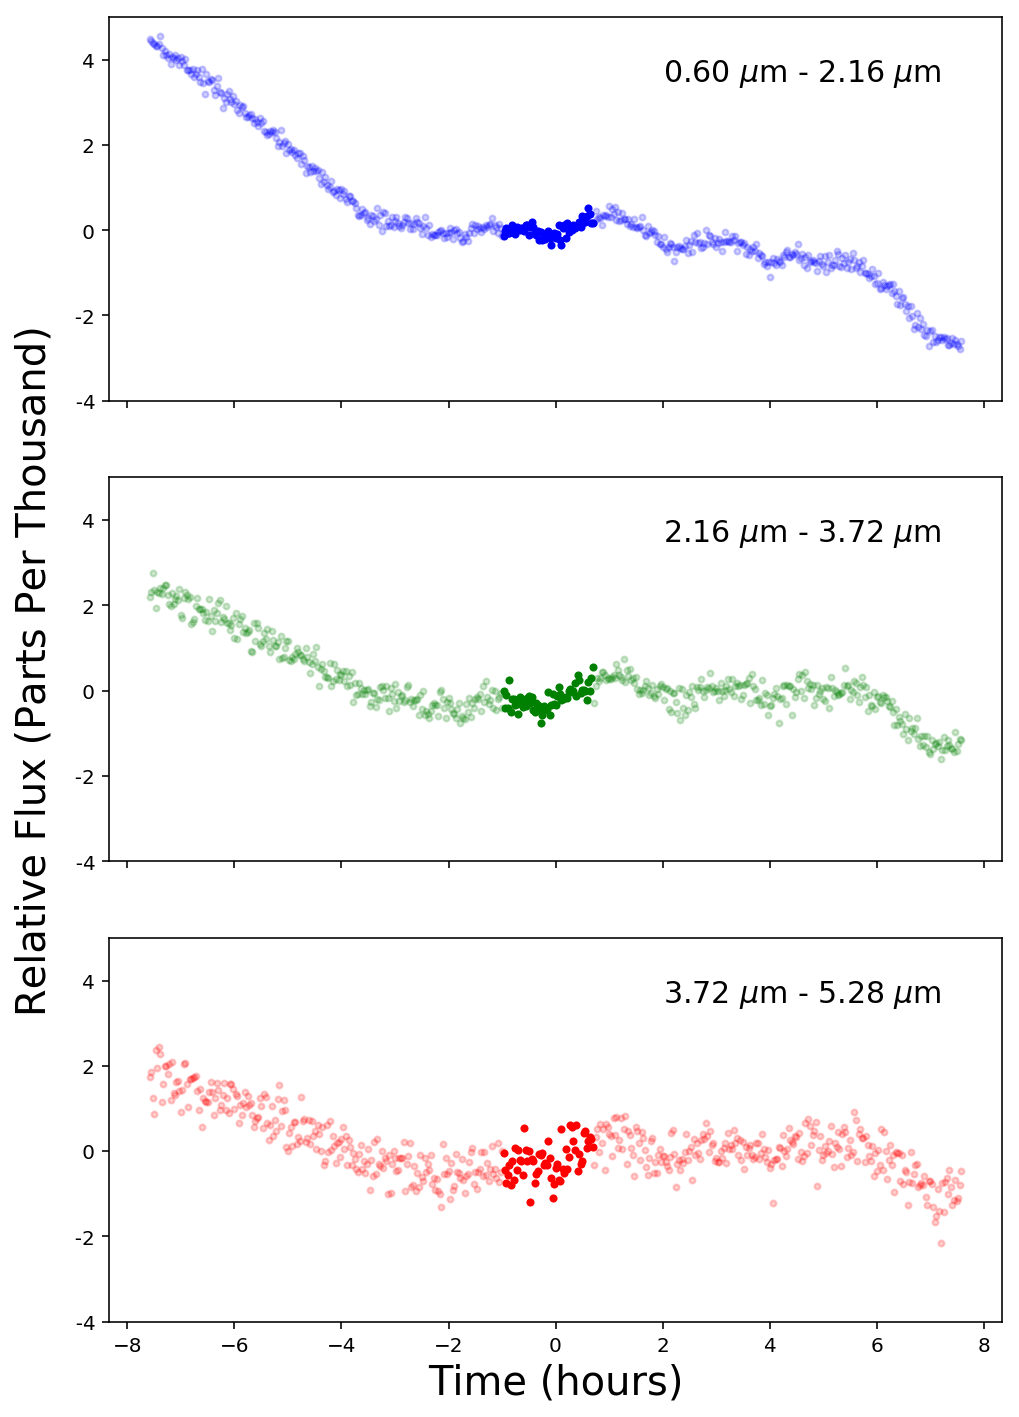

In [146]:
#basedir = '/Users/tgordon/research/libra/notebooks/'
#data = np.loadtxt(basedir + 'tyler4_b_binned_small.txt')
#t = data[0] - np.median(data[0])

figure = pl.figure(figsize=(10, 2))
#data = data[:-1]
fig, axs = pl.subplots(3, 1, figsize=(8, 12), sharex='all')
#axs[0].set_title('Simulated Light Curve with Transit', size=20)
colors = ['r', 'g', 'b']

for i, dat in enumerate(data):
    transit_model = MeanModel(log_off=initial_fit.offsets[i], b=b, rp=r, center=c, duration=d)
    gp = celerite.GP(kernel, mean=transit_model)
    gp.compute(t, yerr=yerr[i])
    mu, var = gp.predict(dat, t, return_var=True)
    planet = transit(t, initial_fit.offsets[i], b, r, c, d)
    axs[2-i].plot(t*24, 1e3*(dat/np.median(dat)-1), colors[i]+'.', alpha=0.2)
    axs[2-i].yaxis.set_major_formatter(FormatStrFormatter('%4.f'))
    axs[2-i].set_ylim([-4, 5])
    axs[2-i].set_yticks((-4, -2, 0, 2, 4))
    axs[2-i].text(2, 3.5, r'{:.2f} $\mu$m - {:.2f} $\mu$m'.format(bins[i+1], bins[i]), size=15)
    
    in_transit = 1e3*(dat[np.abs(t-c)<d/2]/np.median(dat)-1)
    t_in_transit = t[np.abs(t-c)<d/2]
    axs[2-i].plot(t_in_transit*24, in_transit, colors[i]+'.', alpha=1)

axs[1].set_ylabel('Relative Flux (Parts Per Thousand)', size=20)
pl.xlabel('Time (hours)', size=20)


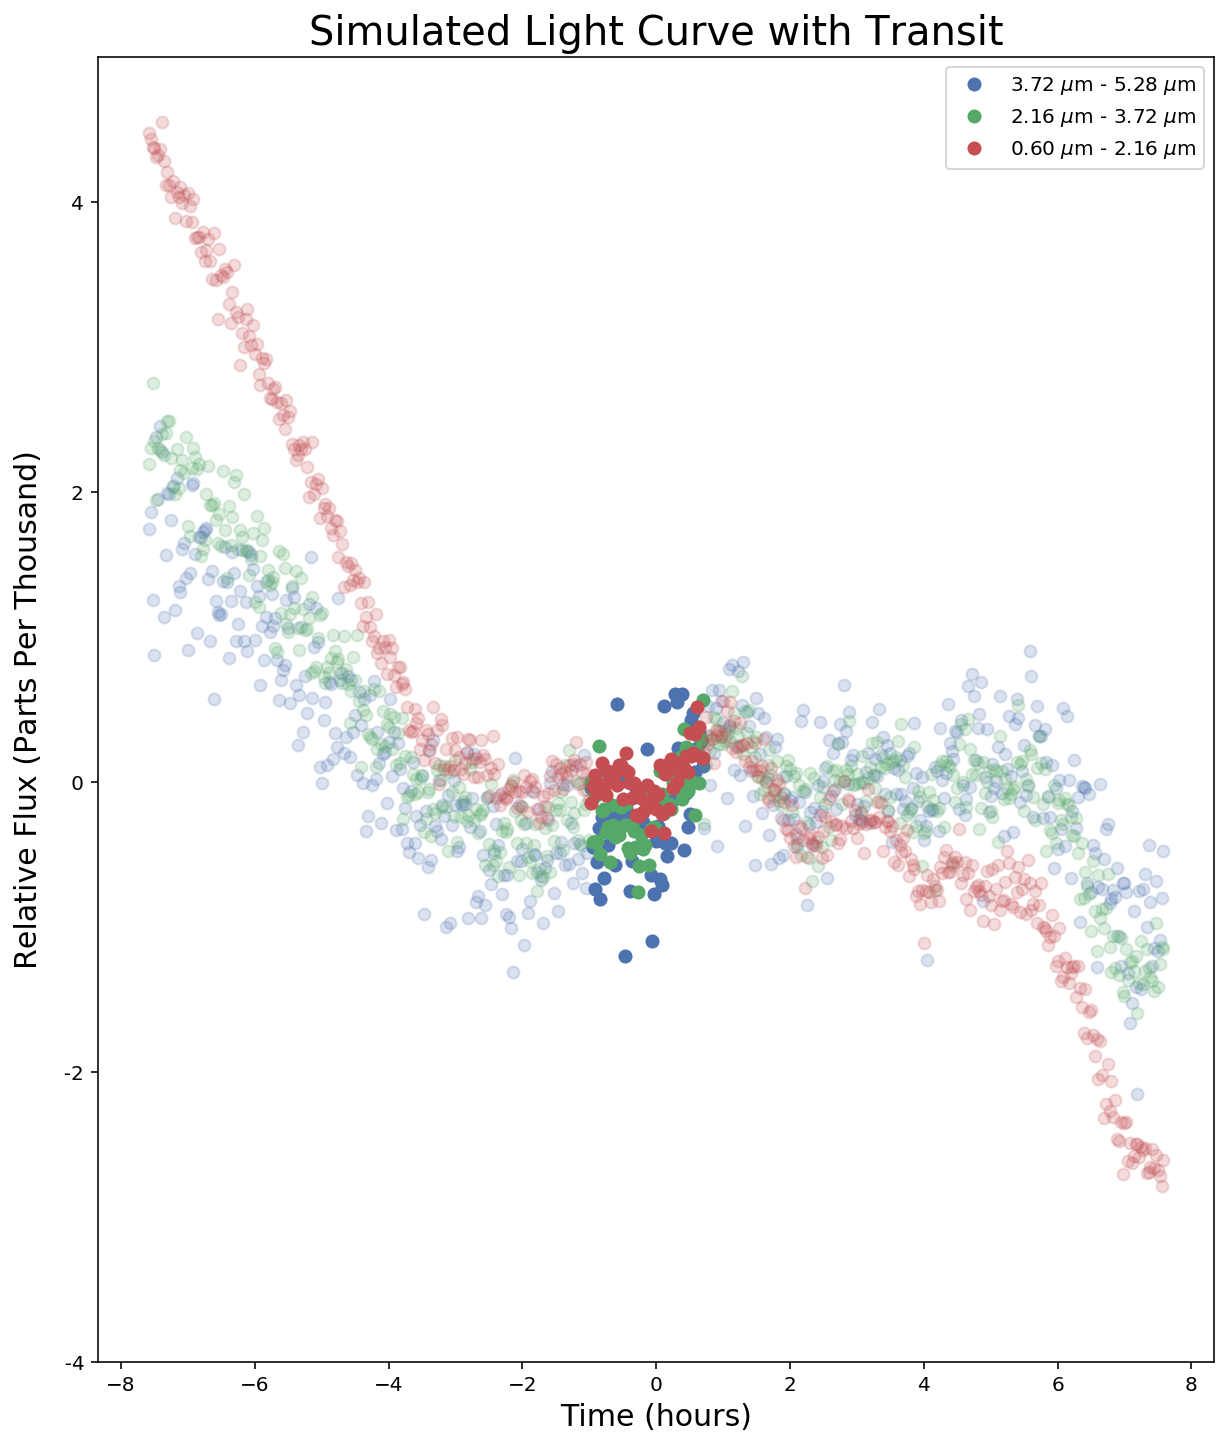

In [68]:
figure = pl.figure(figsize=(12, 2))
#data = data[::-1]
#data = data[:-1]
fig = pl.figure(figsize=(10, 12))
axs = pl.gca()
pl.title('Simulated Light Curve with Transit', size=20)
for i, dat in enumerate(data):
    transit_model = MeanModel(log_off=initial_fit.offsets[i], b=b, rp=r, center=c, duration=d)
    gp = celerite.GP(kernel, mean=transit_model)
    gp.compute(t, yerr=yerr[i])
    mu, var = gp.predict(dat, t, return_var=True)
    planet = transit(t, initial_fit.offsets[i], b, r, c, d)
    color = 'C' + str(i)
    pl.plot(t*24, 1e3*(dat/np.median(dat)-1), 'o'+color, alpha=0.2)
    axs.yaxis.set_major_formatter(FormatStrFormatter('%4.f'))
    pl.ylim([-4, 5])
    axs.set_yticks((-4, -2, 0, 2, 4))
    
    in_transit = 1e3*(dat[np.abs(t-c)<d/2]/np.median(dat)-1)
    t_in_transit = t[np.abs(t-c)<d/2]
    pl.plot(t_in_transit*24, in_transit, 'o'+color, label=r'{:.2f} $\mu$m - {:.2f} $\mu$m'.format(bins[i+1], bins[i]))

pl.ylabel('Relative Flux (Parts Per Thousand)', size=15)
pl.xlabel('Time (hours)', size=15)
pl.legend()

Text(0.5,0,'Time (Hours)')

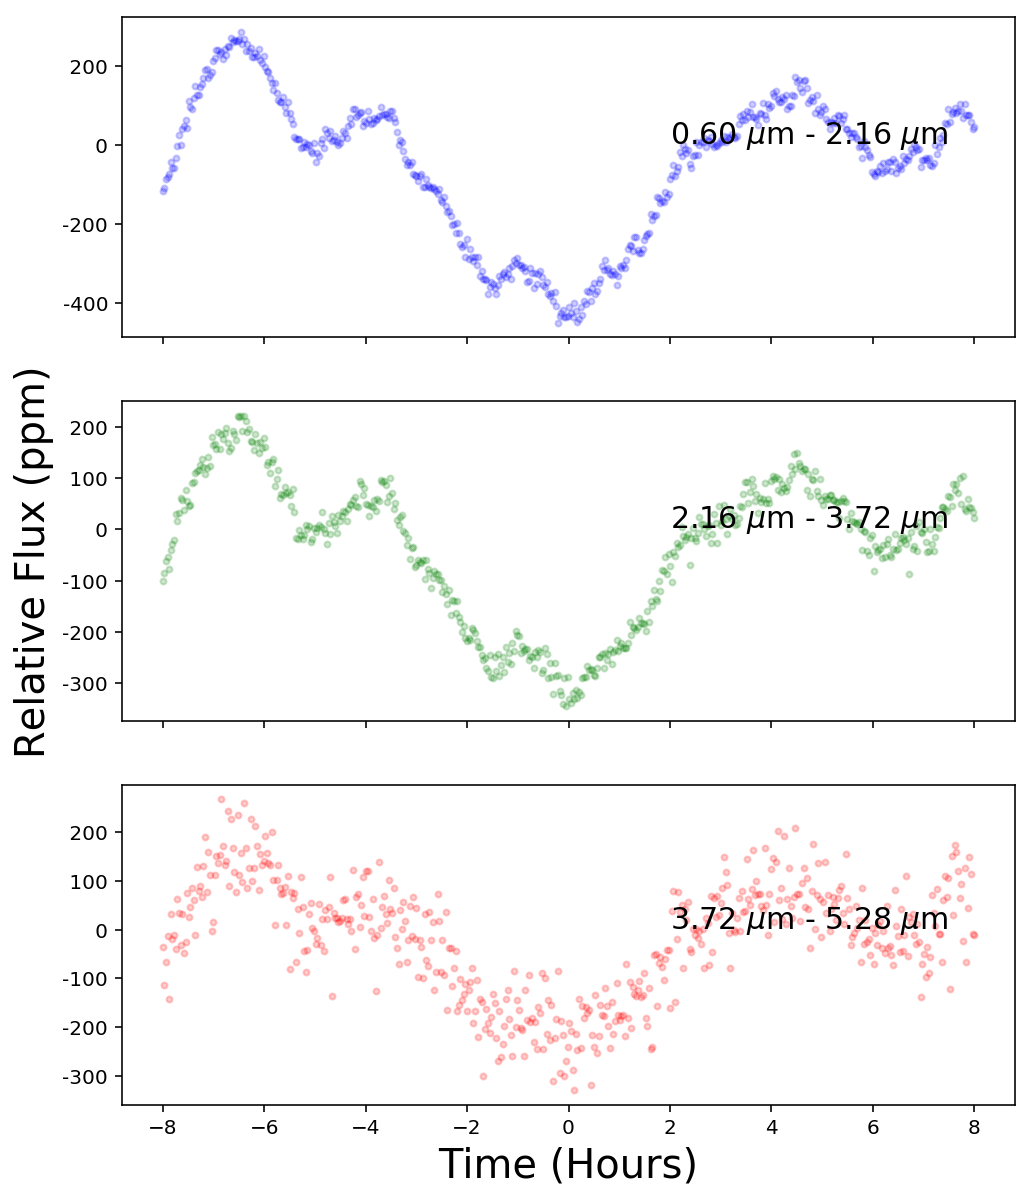

In [158]:
k1_params = [1, 1e6, 0.1, 1e3]
k2_params = [4, 15]
white_noise = [5e2, 5e2, 1e3]
offsets = [np.median(data[0]), np.median(data[1]), np.median(data[2])]
mean_params = [0.0, 0.0, 0.0, 0.1]

initial_fit = model(k1_params, k2_params, white_noise, mean_params, offsets, transit, 
                    kernel.two_celerite_root2_kernel, kernel.scale_kernel, 3)

t = np.linspace(-8, 8, 500)
samp = initial_fit.sample(t)

fig, axs = pl.subplots(3, 1, figsize=(8, 10), sharex='all')
colors = ['r', 'g', 'b']

for i, dat in enumerate(samp):
    transit_model = MeanModel(log_off=initial_fit.offsets[i], b=b, rp=r, center=c, duration=d)
    axs[2-i].plot(t, 1e6*(dat/np.median(dat)-1), colors[i]+'.', alpha=0.2)
    axs[2-i].yaxis.set_major_formatter(FormatStrFormatter('%4.f'))
    #axs[2-i].set_ylim([-10, 10])
    #axs[2-i].set_yticks((-10, -5, 0, 5, 10))
    axs[2-i].text(2, 3.5, r'{:.2f} $\mu$m - {:.2f} $\mu$m'.format(bins[i+1], bins[i]), size=15)
    

axs[1].set_ylabel('Relative Flux (ppm)', size=20)
pl.xlabel('Time (Hours)', size=20)
